# AI-Generated Image Detection using EfficientNet-B0
This notebook trains and evaluates a deep learning model to detect AI-generated images vs real images. 

-Dataset size: 120,000 images. 
-Final accuracy: 98.5%.
-Grad-CAM explainability.


In [2]:
DATA_ROOT = r"C:/Users/saaya/Projects/ai-image-detector/data/ai_forensics"

In [3]:
#!pip install datasets matplotlib scikit-learn tqdm grad-cam

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Enable fastest CuDNN algorithm search
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


c:\Program Files\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [2]:
DATA_ROOT = "C:/Users/saaya/Projects/ai-image-detector/data"

train_dir = "C:/Users/saaya/Projects/ai-image-detector/data/train"
val_dir   = "C:/Users/saaya/Projects/ai-image-detector/data/val"
test_dir  = "C:/Users/saaya/Projects/ai-image-detector/data/test"


print(train_dir, val_dir, test_dir)


C:/Users/saaya/Projects/ai-image-detector/data/train C:/Users/saaya/Projects/ai-image-detector/data/val C:/Users/saaya/Projects/ai-image-detector/data/test


In [3]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])


In [4]:
train_ds = datasets.ImageFolder(root=str(train_dir), transform=train_transform)
val_ds   = datasets.ImageFolder(root=str(val_dir),   transform=val_test_transform)
test_ds  = datasets.ImageFolder(root=str(test_dir),  transform=val_test_transform)

print("Classes:", train_ds.classes)
print("Class mapping:", train_ds.class_to_idx)
print("Train:", Counter([y for _, y in train_ds]))
print("Val:", Counter([y for _, y in val_ds]))
print("Test:", Counter([y for _, y in test_ds]))


Classes: ['FAKE', 'REAL']
Class mapping: {'FAKE': 0, 'REAL': 1}
Train: Counter({0: 42500, 1: 42500})
Val: Counter({0: 7500, 1: 7500})
Test: Counter({0: 10000, 1: 10000})


In [5]:
batch_size = 16

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=2, pin_memory=True, persistent_workers=True
)

val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=True, persistent_workers=True
)

test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=True, persistent_workers=True
)



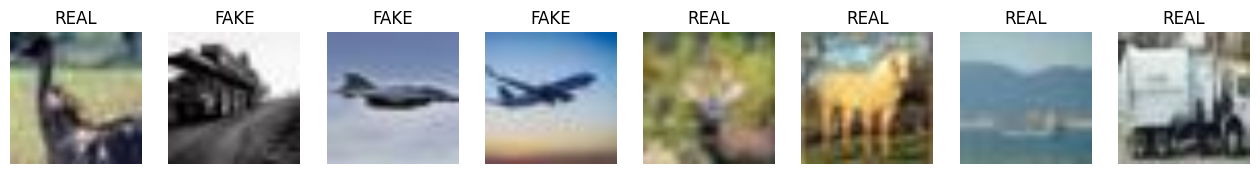

In [6]:
def show_batch(images, labels, class_names):
    images = images[:8].cpu()
    labels = labels[:8].cpu().numpy()
    
    fig, axes = plt.subplots(1, 8, figsize=(16, 3))
    for i, ax in enumerate(axes):
        img = images[i]
        # un-normalize
        img = img * torch.tensor(imagenet_std).view(3,1,1) + torch.tensor(imagenet_mean).view(3,1,1)
        img = img.clamp(0, 1)
        ax.imshow(np.transpose(img.numpy(), (1,2,0)))
        ax.set_title(class_names[labels[i]])
        ax.axis("off")
    plt.show()

imgs, labels = next(iter(train_loader))
show_batch(imgs, labels, train_ds.classes)


In [7]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = out.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Eval", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)

            out = model(imgs)
            loss = criterion(out, labels)

            total_loss += loss.item() * imgs.size(0)
            
            probs = torch.softmax(out, dim=1)
            preds = probs.argmax(1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs[:,1].cpu().numpy())

    return total_loss/total, correct/total, np.array(y_true), np.array(y_pred), np.array(y_prob)


In [8]:
eff_model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

num_features = eff_model.classifier[1].in_features
eff_model.classifier[1] = nn.Linear(num_features, 2)

eff_model = eff_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(eff_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2
)


In [9]:
epochs = 5
best_acc = 0

for epoch in range(epochs):
    print(f"\n[EfficientNet-B0] Epoch {epoch+1}/{epochs}")

    train_loss, train_acc = train_one_epoch(eff_model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _, _ = eval_one_epoch(eff_model, val_loader, criterion)

    print(f"Train  Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val    Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    scheduler.step(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(eff_model.state_dict(), "efficientnet_b0_best.pth")
        print(" Saved new best model!")




[EfficientNet-B0] Epoch 1/5


Train  Loss: 0.1442 | Acc: 0.9452
Val    Loss: 0.0688 | Acc: 0.9752
 Saved new best model!

[EfficientNet-B0] Epoch 2/5


Train  Loss: 0.0794 | Acc: 0.9713
Val    Loss: 0.0579 | Acc: 0.9767
 Saved new best model!

[EfficientNet-B0] Epoch 3/5


Train  Loss: 0.0568 | Acc: 0.9796
Val    Loss: 0.0500 | Acc: 0.9815
 Saved new best model!

[EfficientNet-B0] Epoch 4/5


Train  Loss: 0.0463 | Acc: 0.9835
Val    Loss: 0.0507 | Acc: 0.9827
 Saved new best model!

[EfficientNet-B0] Epoch 5/5


Train  Loss: 0.0372 | Acc: 0.9867
Val    Loss: 0.0425 | Acc: 0.9863
 Saved new best model!



TEST RESULTS
Test Loss: 0.04301367672761648
Test Acc: 0.98525
              precision    recall  f1-score   support

        FAKE       0.98      0.99      0.99     10000
        REAL       0.99      0.98      0.99     10000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



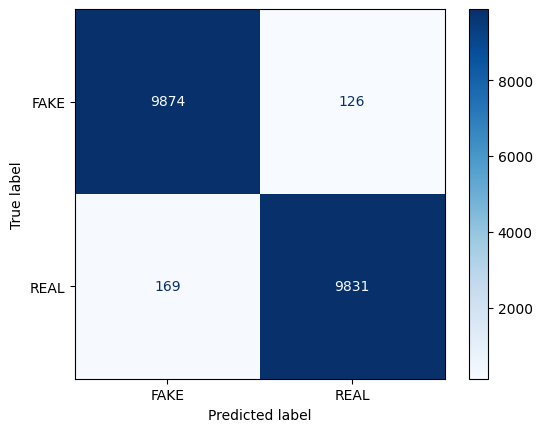

In [10]:
eff_model.load_state_dict(torch.load("efficientnet_b0_best.pth", map_location=device))
eff_model = eff_model.to(device)

test_loss, test_acc, y_true, y_pred, y_prob = eval_one_epoch(
    eff_model, test_loader, criterion
)

print("\nTEST RESULTS")
print("Test Loss:", test_loss)
print("Test Acc:", test_acc)
print(classification_report(y_true, y_pred, target_names=train_ds.classes))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=train_ds.classes).plot(cmap="Blues")
plt.show()

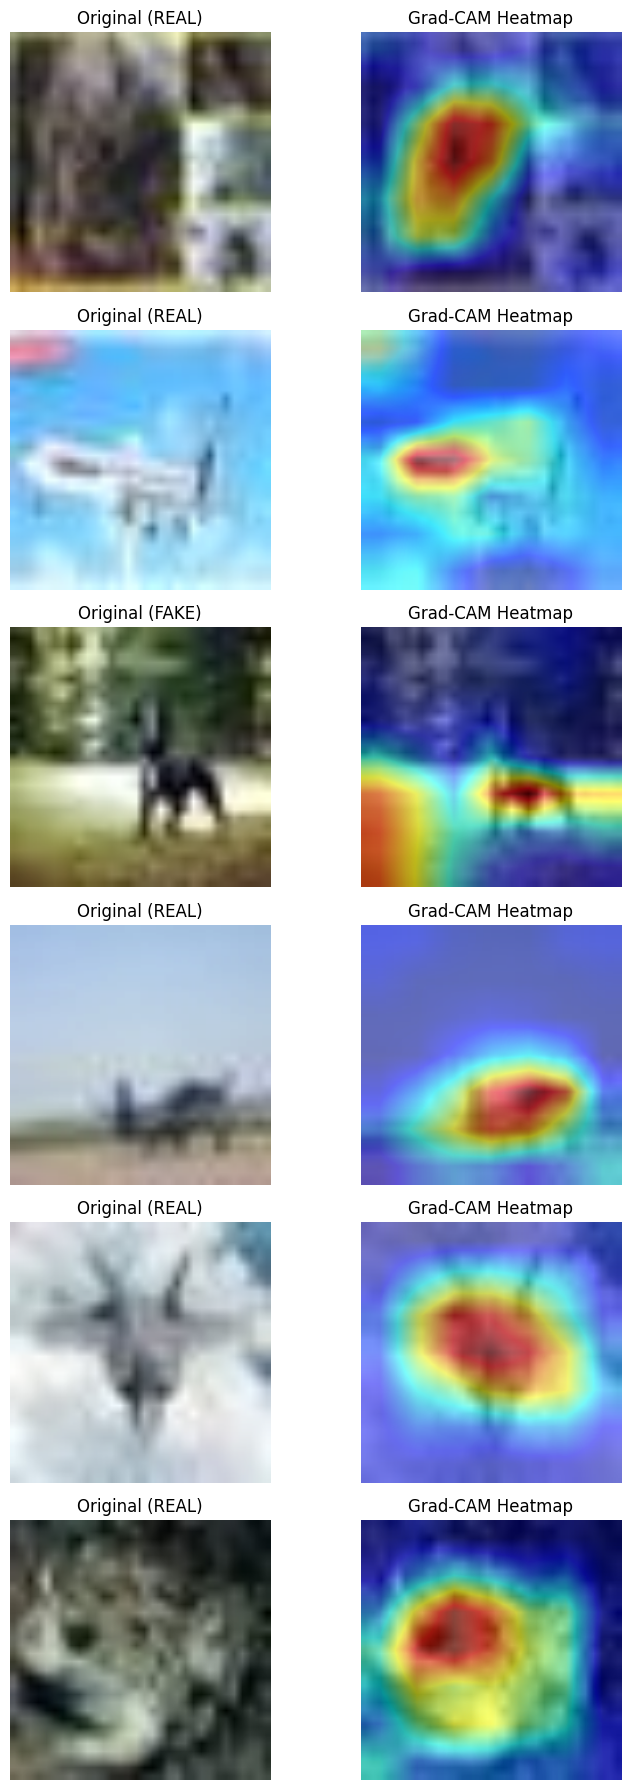

In [19]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import random

# Load best model weights
eff_model.load_state_dict(torch.load("efficientnet_b0_best.pth", map_location=device))
eff_model = eff_model.to(device)
eff_model.eval()

# Grad-CAM target layer: last feature block of EfficientNet-B0
target_layers = [eff_model.features[-1]]

# Initialize CAM object
cam = GradCAM(model=eff_model, target_layers=target_layers)

# Number of examples to visualize
n_samples = 6
indices = random.sample(range(len(test_ds)), n_samples)

fig, axes = plt.subplots(n_samples, 2, figsize=(8, n_samples * 3))

for row, idx in enumerate(indices):
    img_tensor, label = test_ds[idx]

    # Prepare tensor for model (batch dimension)
    input_tensor = img_tensor.unsqueeze(0).to(device)

    # Generate Grad-CAM heatmap
    grayscale_cam = cam(
        input_tensor=input_tensor,
        targets=[ClassifierOutputTarget(label)]
    )[0]  # Remove batch dim

    # Convert tensor -> numpy (unnormalized for visualization)
    img_np = img_tensor.cpu().numpy()
    img_np = img_np * np.array(imagenet_std)[:, None, None] + np.array(imagenet_mean)[:, None, None]
    img_np = np.clip(img_np, 0, 1)
    img_np = np.transpose(img_np, (1, 2, 0))

    # Overlay heatmap
    cam_image = show_cam_on_image(img_np.astype(np.float32), grayscale_cam, use_rgb=True)

    # Display original
    axes[row, 0].imshow(img_np)
    axes[row, 0].set_title(f"Original ({train_ds.classes[label]})")
    axes[row, 0].axis("off")

    # Display Grad-CAM
    axes[row, 1].imshow(cam_image)
    axes[row, 1].set_title("Grad-CAM Heatmap")
    axes[row, 1].axis("off")

plt.tight_layout()
plt.show()


In [17]:
pip install grad-cam


  Using cached grad_cam-1.5.5-py3-none-any.whl
  Using cached ttach-0.0.3-py3-none-any.whl.metadata (5.2 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.9 MB 3.7 MB/s eta 0:00:04
   ---- ----------------------------------- 1.3/12.9 MB 3.0 MB/s eta 0:00:04
   ---- ----------------------------------- 1.6/12.9 MB 2.5 MB/s eta 0:00:05
   ----- ---------------------------------- 1.8/12.9 MB 2.2 MB/s eta 0:00:06
   ----- ---------------------------------- 1.8/12.9 MB 2.2 MB/s eta 0:00:06
   ----- ---------------------------------- 1.8/12.9 MB 2.2 MB/s eta 0:00:06
   ----- ---------------------------------- 1.8/12.9 MB 2.2 MB/s eta

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerate 0.33.0 requires numpy<2.0.0,>=1.17, but you have numpy 2.2.6 which is incompatible.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
